इसमें 2012 से 2014 के बीच 3 वर्षों के घंटेवार बिजली लोड और तापमान मान शामिल हैं। कार्य भविष्य में बिजली लोड के मानों का पूर्वानुमान लगाना है। इस उदाहरण में, हम केवल ऐतिहासिक लोड डेटा का उपयोग करके एक समय चरण आगे का पूर्वानुमान कैसे लगाएं, यह दिखाते हैं।

ताओ हांग, पियरे पिन्सन, शू फैन, हमीदरेज़ा ज़ारिपोर, अल्बर्टो ट्रोक्कोली और रॉब जे. हाइंडमैन, "संभाव्य ऊर्जा पूर्वानुमान: ग्लोबल एनर्जी फोरकास्टिंग प्रतियोगिता 2014 और आगे", इंटरनेशनल जर्नल ऑफ फोरकास्टिंग, वॉल्यूम 32, नंबर 3, पृष्ठ 896-913, जुलाई-सितंबर, 2016।


## आवश्यक डिपेंडेंसीज़ इंस्टॉल करें
समाधान के लिए आवश्यक कुछ डिपेंडेंसीज़ को इंस्टॉल करके शुरुआत करें। ये लाइब्रेरीज़ और उनके संबंधित संस्करण समाधान के लिए काम करने के लिए जाने जाते हैं:

* `statsmodels == 0.12.2`
* `matplotlib == 3.4.2`
* `scikit-learn == 0.24.2`


In [16]:
!pip install statsmodels

/bin/sh: pip: command not found


In [17]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [18]:
energy = load_data('./data')[['load']]
energy.head(10)

load
2012-01-01 00:00:00 2,698.00
2012-01-01 01:00:00 2,558.00
2012-01-01 02:00:00 2,444.00
2012-01-01 03:00:00 2,402.00
2012-01-01 04:00:00 2,403.00
2012-01-01 05:00:00 2,453.00
2012-01-01 06:00:00 2,560.00
2012-01-01 07:00:00 2,719.00
2012-01-01 08:00:00 2,916.00
2012-01-01 09:00:00 3,105.00

जनवरी 2012 से दिसंबर 2014 तक उपलब्ध सभी लोड डेटा प्लॉट करें


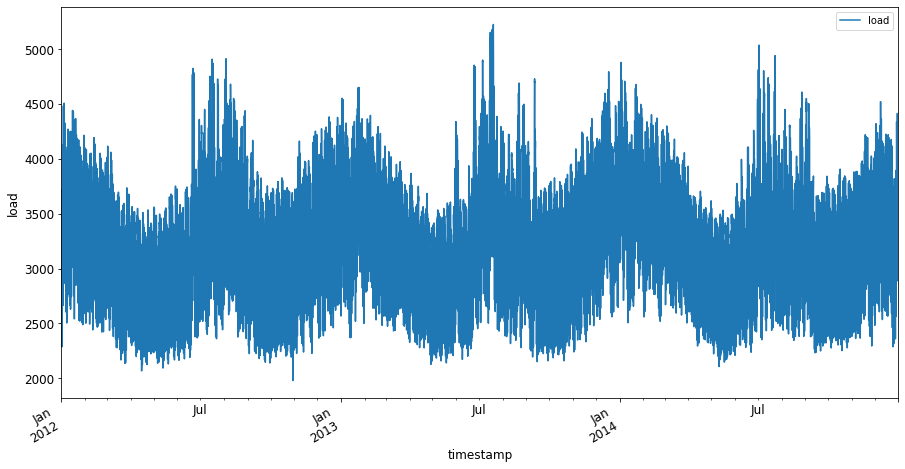

In [19]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## प्रशिक्षण और परीक्षण डेटा सेट बनाएं

डेटा सेट तैयार करना मशीन लर्निंग मॉडल के विकास में एक महत्वपूर्ण कदम है। यह सुनिश्चित करता है कि मॉडल को प्रशिक्षित करने और उसका मूल्यांकन करने के लिए उपयुक्त और संतुलित डेटा उपलब्ध हो।

### डेटा को विभाजित करना

डेटा को प्रशिक्षण और परीक्षण सेट में विभाजित करना एक सामान्य प्रक्रिया है। यह मॉडल के प्रदर्शन का आकलन करने में मदद करता है। आमतौर पर, डेटा को निम्नलिखित अनुपात में विभाजित किया जाता है:

- **प्रशिक्षण सेट**: 70-80% डेटा
- **परीक्षण सेट**: 20-30% डेटा

### डेटा विभाजन के लिए चरण

1. **डेटा को लोड करें**  
   सबसे पहले, अपने डेटा को लोड करें। यह डेटा फ़ाइल, डेटाबेस, या API से आ सकता है। उदाहरण के लिए:  
   ```python
   data = load_data("data.csv")
   ```

2. **डेटा को शफल करें**  
   डेटा को शफल करना महत्वपूर्ण है ताकि यह सुनिश्चित हो सके कि यह यादृच्छिक है और किसी भी क्रमबद्ध पैटर्न का पालन नहीं करता।  
   ```python
   shuffled_data = shuffle(data)
   ```

3. **डेटा को विभाजित करें**  
   डेटा को प्रशिक्षण और परीक्षण सेट में विभाजित करें।  
   ```python
   train_data, test_data = split_data(shuffled_data, train_ratio=0.8)
   ```

### [!TIP]  
यदि आपके पास सीमित डेटा है, तो क्रॉस-वैलिडेशन का उपयोग करें। यह डेटा को कई बार विभाजित करता है और प्रत्येक विभाजन पर मॉडल का परीक्षण करता है।

### डेटा विभाजन में सामान्य गलतियाँ

- **डेटा लीक**: सुनिश्चित करें कि परीक्षण सेट में ऐसी जानकारी शामिल न हो जो प्रशिक्षण सेट से संबंधित हो।  
- **असंतुलित डेटा**: यदि आपके डेटा में वर्गों का असंतुलन है, तो विभाजन करते समय इसे ध्यान में रखें।  
- **पर्याप्त परीक्षण डेटा न होना**: परीक्षण सेट को बहुत छोटा न रखें, क्योंकि यह मॉडल के प्रदर्शन का सटीक आकलन नहीं देगा।  

### निष्कर्ष

डेटा को सही तरीके से विभाजित करना मॉडल की सटीकता और विश्वसनीयता सुनिश्चित करने के लिए आवश्यक है। हमेशा सुनिश्चित करें कि आपका डेटा विविध और संतुलित हो।


In [20]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'    

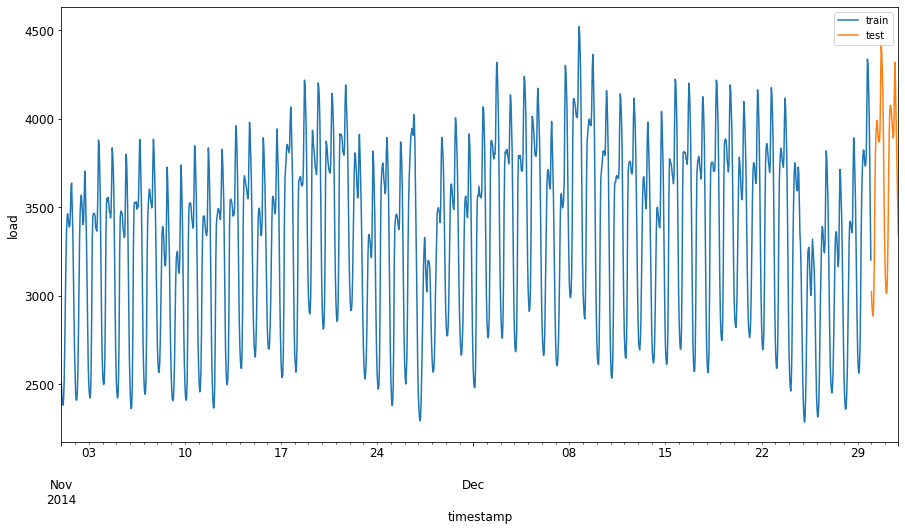

In [21]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [22]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [23]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

load
2014-11-01 00:00:00  0.10
2014-11-01 01:00:00  0.07
2014-11-01 02:00:00  0.05
2014-11-01 03:00:00  0.04
2014-11-01 04:00:00  0.06
2014-11-01 05:00:00  0.10
2014-11-01 06:00:00  0.19
2014-11-01 07:00:00  0.31
2014-11-01 08:00:00  0.40
2014-11-01 09:00:00  0.48

मूल बनाम स्केल किया गया डेटा:


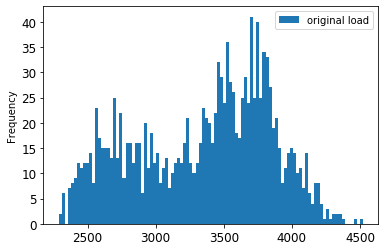

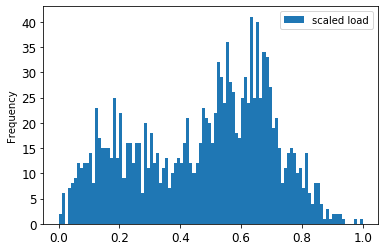

In [24]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

आइए परीक्षण डेटा को भी स्केल करें


In [25]:
test['load'] = scaler.transform(test)
test.head()

load
2014-12-30 00:00:00  0.33
2014-12-30 01:00:00  0.29
2014-12-30 02:00:00  0.27
2014-12-30 03:00:00  0.27
2014-12-30 04:00:00  0.30

In [26]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [27]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.239
Date:                            Thu, 30 Sep 2021   AIC                          -6942.477
Time:                                    14:36:28   BIC                          -6911.050
Sample:                                11-01-2014   HQIC                         -6930.725
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8403      0.016     52.226      0.000       0.809       0.872
ar.L2         -0.5220      0.034   

प्रत्येक HORIZON चरण के लिए एक परीक्षण डेटा बिंदु बनाएं।


In [28]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

load  load+1  load+2
2014-12-30 00:00:00  0.33    0.29    0.27
2014-12-30 01:00:00  0.29    0.27    0.27
2014-12-30 02:00:00  0.27    0.27    0.30
2014-12-30 03:00:00  0.27    0.30    0.41
2014-12-30 04:00:00  0.30    0.41    0.57

In [29]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

भविष्यवाणियों की वास्तविक भार से तुलना करें


In [30]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

timestamp    h  prediction   actual
0 2014-12-30 00:00:00  t+1    3,008.74 3,023.00
1 2014-12-30 01:00:00  t+1    2,955.53 2,935.00
2 2014-12-30 02:00:00  t+1    2,900.17 2,899.00
3 2014-12-30 03:00:00  t+1    2,917.69 2,886.00
4 2014-12-30 04:00:00  t+1    2,946.99 2,963.00

सभी भविष्यवाणियों पर **मीन एब्सोल्यूट पर्सेंटेज एरर (MAPE)** की गणना करें

$$MAPE = \frac{1}{n} \sum_{t=1}^{n}|\frac{actual_t - predicted_t}{actual_t}|$$


In [31]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
Name: APE, dtype: float64


In [32]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  0.5570581332313952 %


In [33]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  1.1460048657704118 %


परीक्षण सेट के पहले सप्ताह के लिए भविष्यवाणियों बनाम वास्तविक मानों का ग्राफ बनाएं


No handles with labels found to put in legend.


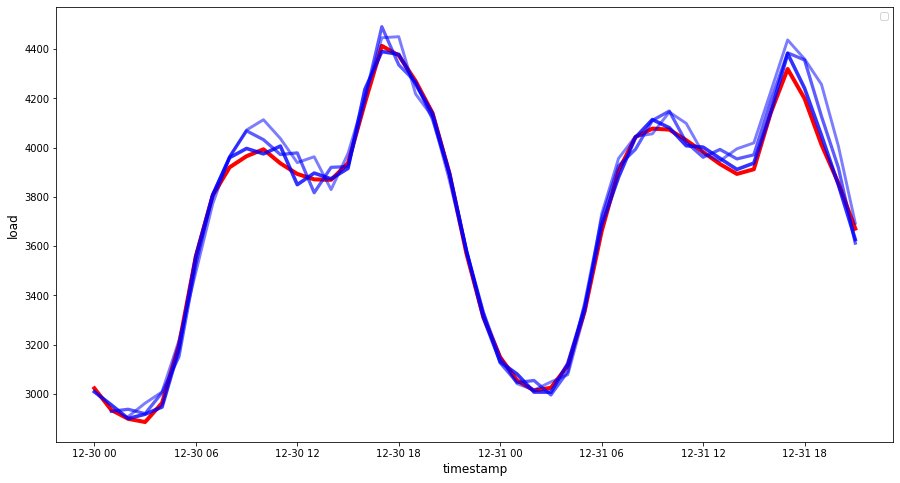

In [34]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()


---

**अस्वीकरण**:  
यह दस्तावेज़ AI अनुवाद सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) का उपयोग करके अनुवादित किया गया है। जबकि हम सटीकता के लिए प्रयास करते हैं, कृपया ध्यान दें कि स्वचालित अनुवाद में त्रुटियां या अशुद्धियां हो सकती हैं। मूल भाषा में उपलब्ध मूल दस्तावेज़ को आधिकारिक स्रोत माना जाना चाहिए। महत्वपूर्ण जानकारी के लिए, पेशेवर मानव अनुवाद की सिफारिश की जाती है। इस अनुवाद के उपयोग से उत्पन्न किसी भी गलतफहमी या गलत व्याख्या के लिए हम उत्तरदायी नहीं हैं।  
